# 🔹UFC Fight Predictor Feature Engineering

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 1. Import Libraries and Setup Environment

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the project root
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Import from /src
sys.path.append(os.path.join(project_root, 'src'))
from helpers import *
from io_model import *
from data import UFCData

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 2. Load Data

In [2]:
# Define the path to the CSV file
file_path = os.path.join(project_root, 'data', 'processed', 'ufc_etl.csv')

# Load the CSV into a DataFrame
try:
    ufc_df = pd.read_csv(file_path)
    print_header(f"Data loaded succesfully", color='bright_green')
except Exception as e:
    print_header(f"Error loading data: {e}", color='bright_red')

╔═══════════════════════════╗
║  Data loaded succesfully  ║
╚═══════════════════════════╝


<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 3. Initialize UFCData object

In [3]:
ufc_data = UFCData(ufc_df)
ufc_data

📊 UFC Dataset Summary
----------------------------------------
🧪 Total samples      : 5259
🧪 Train/Test split  : 4207 / 1052
🧪 Total features     : 69

🔢 Numerical features : 64
🔠 Categorical features: 5
    - Binary          : 2
    - Multiclass      : 3

🏷 Label distribution (raw):
   - Class 0: 3035 (57.7%)
   - Class 1: 2224 (42.3%)

✅ No missing values detected

📈 Feature summary statistics (train set):
                                mean      std       min       max
RedOdds                     -115.052  276.923 -2100.000   700.000
BlueOdds                      57.943  251.903 -1100.000  1150.000
NumberOfRounds                 3.217    0.623     3.000     5.000
BlueCurrentLoseStreak          0.555    0.810     0.000     5.000
BlueCurrentWinStreak           1.131    1.485     0.000    12.000
BlueDraws                      0.022    0.151     0.000     2.000
BlueAvgSigStrLanded           20.129   20.368     0.000   144.500
BlueAvgSigStrPct               0.453    0.111     0.000     

## 4. Feature Engineering

### Categorical Data

### Stance
- **Orthodox Stance:** A fighter in orthodox stance leads with their left foot and left hand, making it the natural stance for right-handed individuals. 
- **Southpaw Stance:** A fighter in southpaw stance leads with their right foot and right hand, making it the natural stance for left-handed individuals. 
- **Open Stance Matchup:** When one fighter is orthodox and the other is southpaw, it creates an "open stance" matchup. This differs from a "closed stance" where both fighters are in the same stance (e.g., both orthodox or both southpaw)
- **Switch:** When a fighter switches from an orthodox to a southpaw stance or vice versa, it can disrupt their opponent's rhythm, causing them to miss or react incorrectly to strikes. 

### Feature Construction

In [4]:
# Finish Rate (Red & Blue):
RedFinishRate = (ufc_df['RedWinsByKO'] + ufc_df['RedWinsBySubmission'] + ufc_df['RedWinsByTKODoctorStoppage']) / ufc_df['RedWins'].replace(0, 1)
BlueFinishRate = (ufc_df['BlueWinsByKO'] + ufc_df['BlueWinsBySubmission'] + ufc_df['BlueWinsByTKODoctorStoppage']) / ufc_df['BlueWins'].replace(0, 1)
ufc_df['FinishRateDif'] = BlueFinishRate - RedFinishRate

In [5]:
#Win Ratio (Red & Blue)
RedWinRatio = ufc_df['RedWins'] / (ufc_df['RedWins'] + ufc_df['RedLosses']).replace(0, 1)
BlueWinRatio = ufc_df['BlueWins'] / (ufc_df['BlueWins'] + ufc_df['BlueLosses']).replace(0, 1)
ufc_df['WinRatioDif']= BlueWinRatio - RedWinRatio 

In [6]:
# Experience per Age
RedExpPerAge = ufc_df['RedTotalRoundsFought'] / ufc_df['RedAge']
BlueExpPerAge = ufc_df['BlueTotalRoundsFought'] / ufc_df['BlueAge']
ufc_df['ExpPerAgeDif'] = BlueExpPerAge - RedExpPerAge

In [7]:
# Reach Advantage Ratio
ufc_df['ReachAdvantageRatioDif'] = ufc_df['BlueReachCms'] / ufc_df['RedReachCms']

In [8]:
# Height/Reach Ratio
RedHeightReachRatio = ufc_df['RedHeightCms'] / ufc_df['RedReachCms']
BlueHeightReachRatio = ufc_df['BlueHeightCms'] / ufc_df['BlueReachCms']
ufc_df['HeightReachRatioDif']= BlueHeightReachRatio - RedHeightReachRatio

In [9]:
# Win By Decision
BlueWinsByDecision = ufc_df[['BlueWinsByDecisionMajority', 'BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous']].sum(axis=1)
RedWinsByDecision = ufc_df[['RedWinsByDecisionMajority', 'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous']].sum(axis=1)
ufc_df['WinsByDecisionDif']=BlueWinsByDecision- RedWinsByDecision

In [10]:
# Decision Rate
BlueDecisionRate = BlueWinsByDecision / ufc_df['BlueWins'].replace(0, 1)  # Evitar división por cero
RedDecisionRate = RedWinsByDecision  / ufc_df['RedWins'].replace(0, 1)  # Evitar división por cero
ufc_df['DecisionRateDif']= BlueDecisionRate - RedDecisionRate

In [11]:
# Odds Dif
ufc_df['OddsDif'] = ufc_df['BlueOdds'] - ufc_df['RedOdds']

In [12]:
# AvgSigStrLandedDif
ufc_df['AvgSigStrLandedDif'] = ufc_df['BlueAvgSigStrLanded'] - ufc_df['RedAvgSigStrLanded']

In [13]:
# AvgSigStrPctDif
ufc_df['AvgSigStrPctDif'] = ufc_df['BlueAvgSigStrPct'] - ufc_df['RedAvgSigStrPct']

In [14]:
# AvgSubAttDif
ufc_df['AvgSubAttDif'] = ufc_df['BlueAvgSubAtt'] - ufc_df['RedAvgSubAtt']

In [15]:
# AvgTDLandedDif
ufc_df['AvgTDLandedDif'] = ufc_df['BlueAvgTDLanded'] - ufc_df['RedAvgTDLanded']

In [16]:
# AvgTDPctDif
ufc_df['AvgTDPctDif'] = ufc_df['BlueAvgTDPct'] - ufc_df['RedAvgTDPct']

## 5. Update UFCData object

In [17]:
ufc_data = UFCData(ufc_df)
ufc_data

📊 UFC Dataset Summary
----------------------------------------
🧪 Total samples      : 5259
🧪 Train/Test split  : 4207 / 1052
🧪 Total features     : 81

🔢 Numerical features : 76
🔠 Categorical features: 5
    - Binary          : 2
    - Multiclass      : 3

🏷 Label distribution (raw):
   - Class 0: 3035 (57.7%)
   - Class 1: 2224 (42.3%)

✅ No missing values detected

📈 Feature summary statistics (train set):
                                mean      std       min       max
RedOdds                     -115.052  276.923 -2100.000   700.000
BlueOdds                      57.943  251.903 -1100.000  1150.000
NumberOfRounds                 3.217    0.623     3.000     5.000
BlueCurrentLoseStreak          0.555    0.810     0.000     5.000
BlueCurrentWinStreak           1.131    1.485     0.000    12.000
BlueDraws                      0.022    0.151     0.000     2.000
BlueAvgSigStrLanded           20.129   20.368     0.000   144.500
BlueAvgSigStrPct               0.453    0.111     0.000     

## 6. Feature Selection

Dado lo siguiente:
-  LoseStreakDif: BlueCurrentLoseStreak - RedCurrentLoseStreak
-  WinStreakDif: BlueCurrentWinStreak - RedCurrentWinStreak
-  LongestWinStreakDif: BlueLongestWinStreak - 'RedLongestWinStreak
-  WinDif: BlueWins - RedWins
-  LossDif: BlueLosses - RedLosses
-  TotalTitleBoutDif: BlueTotalTitleBouts - RedTotalTitleBouts
-  KODif: BlueWinsByKO - RedWinsByKO
-  SubDif: BlueWinsBySubmission - RedWinsBySubmission
-  HeightDif: BlueHeightCms - RedHeightCms
-  ReachDif: BlueReachCms - RedReachCms
-  AgeDif: BlueAge - RedAge
-  Odds Dif: BlueOdds - RedOdds
-  AvgSigStrLandedDif: BlueAvgSigStrLanded - RedAvgSigStrLanded
-  AvgSigSTrPctDif: BlueAvgSigStrPct - RedAvgSigStrPct
-  AvgSubAttDif: BlueAvgSubAtt- RedAvgSubAtt
-  AvgTDLandedDif: BlueAvgTDLanded- RedAvgTDLanded
-  AvgTDPctDif: BlueAvgTDPct- RedAvgTDPct
-  
Se eliminan ciertas columnas que pueden ser redundantes.

In [18]:
ufc_df=ufc_df.drop(['BlueCurrentLoseStreak', 'RedCurrentLoseStreak','BlueCurrentWinStreak',
                      'RedCurrentWinStreak','BlueLongestWinStreak', 'RedLongestWinStreak', 'BlueWins',
                      'RedWins','BlueLosses','RedLosses', 'BlueTotalRoundsFought','RedTotalRoundsFought',
                      'BlueTotalTitleBouts', 'RedTotalTitleBouts', 'BlueWinsByKO', 'RedWinsByKO', 'BlueWinsBySubmission',
                      'RedWinsBySubmission','BlueHeightCms','RedHeightCms','BlueReachCms','RedReachCms',
                      'BlueAge', 'RedAge', 'BlueOdds','RedOdds', 'BlueAvgSigStrLanded', 'RedAvgSigStrLanded',
                      'BlueAvgSigStrPct', 'RedAvgSigStrPct', 'BlueAvgSubAtt', 'RedAvgSubAtt', 
                      'BlueAvgTDLanded', 'RedAvgTDLanded', 'BlueAvgTDPct', 'RedAvgTDPct'], axis=1)

También aquellas relacionadas con los features construidos:
- WinsByDecisionDif
- DecisionRateDif
- FinishRateDif


In [19]:
ufc_df=ufc_df.drop(['BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous',
       'BlueWinsByTKODoctorStoppage', 'RedWinsByDecisionMajority',
       'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous',
       'RedWinsByTKODoctorStoppage','BlueWinsByDecisionMajority'], axis=1)

### Low Variance columns
- BlueDraws
- RedDraws
- BlueWeightLbs
- RedWeightLbs

In [20]:
ufc_df = ufc_df.drop(['BlueDraws','RedDraws','BlueWeightLbs','RedWeightLbs'], axis=1)

## 7. Update UFCData object

In [21]:
ufc_data = UFCData(ufc_df)
ufc_data

📊 UFC Dataset Summary
----------------------------------------
🧪 Total samples      : 5259
🧪 Train/Test split  : 4207 / 1052
🧪 Total features     : 33

🔢 Numerical features : 28
🔠 Categorical features: 5
    - Binary          : 2
    - Multiclass      : 3

🏷 Label distribution (raw):
   - Class 0: 3035 (57.7%)
   - Class 1: 2224 (42.3%)

✅ No missing values detected

📈 Feature summary statistics (train set):
                           mean      std       min       max
NumberOfRounds            3.217    0.623     3.000     5.000
LoseStreakDif             0.010    1.016    -6.000     6.000
WinStreakDif             -0.121    2.028   -18.000    10.000
LongestWinStreakDif      -0.743    2.111   -12.000    14.000
WinDif                   -1.539    4.372   -28.000    23.000
LossDif                  -0.073    3.237   -19.000    14.000
TotalRoundDif            -5.712   19.055  -448.000    87.000
TotalTitleBoutDif        -0.329    1.805   -15.000    15.000
KODif                    -0.540    2.29

## 8. Check Correlation Matrix

In [22]:
status = False
ufc_data.compute_corr(processed = status)
ufc_data.top_corr(processed = status)

,Feature 1,Feature 2,Correlation
283,SigStrDif,AvgSigStrLandedDif,1.000000
310,AvgTDDif,AvgTDLandedDif,1.000000
158,TotalRoundDif,ExpPerAgeDif,0.980792
249,ReachDif,ReachAdvantageRatioDif,0.875999
103,WinDif,TotalRoundDif,0.855496
115,WinDif,ExpPerAgeDif,0.835885
161,TotalRoundDif,WinsByDecisionDif,0.727268
118,WinDif,WinsByDecisionDif,0.720535
335,ExpPerAgeDif,WinsByDecisionDif,0.719195
317,FinishRateDif,DecisionRateDif,0.649012


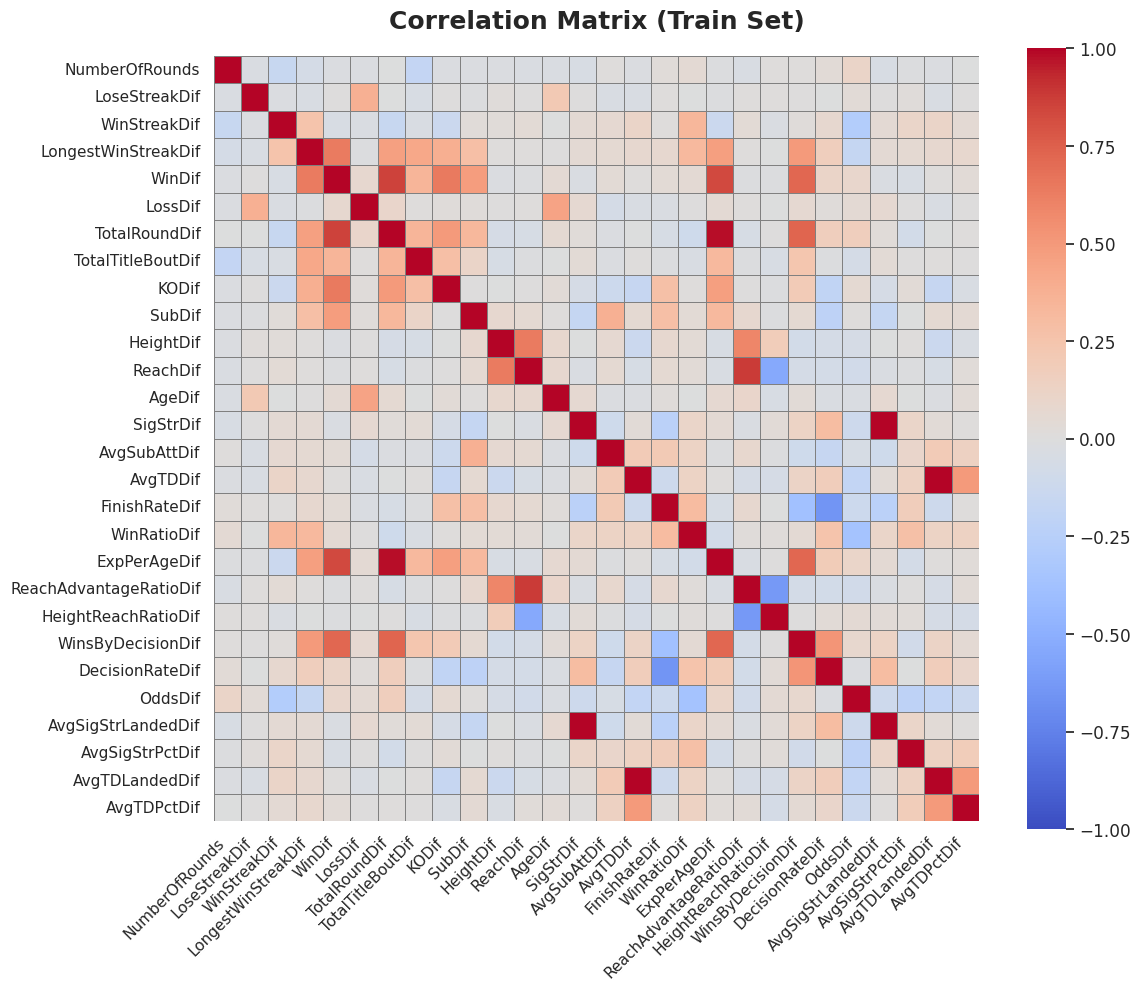

In [23]:
ufc_data.plot_corr(processed = status)

## 9. Redundant Column
- Number of Rounds: Equivalent to Titlebout
- TotalRoundDif: BlueTotalRoundsFought - RedTotalRoundsFought (better to use ExpPerAgeDif)
- AvgTDDif: Already calculated
- SigStrDif: Already calculated

In [24]:
ufc_df = ufc_df.drop(['NumberOfRounds', 'TotalRoundDif', 'AvgTDDif', 'SigStrDif'], axis=1)

In [25]:
# Preview the first few records
display(ufc_df.head())
display(ufc_df.columns)

,TitleBout,Gender,BlueStance,RedStance,LoseStreakDif,WinStreakDif,LongestWinStreakDif,WinDif,LossDif,TotalTitleBoutDif,...,ExpPerAgeDif,ReachAdvantageRatioDif,HeightReachRatioDif,WinsByDecisionDif,DecisionRateDif,OddsDif,AvgSigStrLandedDif,AvgSigStrPctDif,AvgTDLandedDif,AvgTDPctDif
0,False,MALE,Southpaw,Orthodox,-1,5,-2,-2,0,-4,...,-0.477778,1.055556,-0.065058,-4,-0.283333,-455.0,0.25,-0.02,-1.83,0.02
1,False,MALE,Orthodox,Orthodox,0,0,-2,-12,-9,0,...,-1.222222,1.000000,0.028571,-9,-0.293233,-272.0,2.69,0.06,0.20,-0.27
2,False,MALE,Orthodox,Southpaw,-1,4,0,0,-1,0,...,-0.077799,0.955882,0.028733,-2,-0.500000,705.0,-1.12,-0.05,1.72,-0.05
3,False,MALE,Orthodox,Orthodox,1,0,-1,3,5,0,...,0.453704,0.987013,0.025803,2,0.100000,610.0,2.68,0.02,-3.62,-0.41
4,False,MALE,Orthodox,Orthodox,0,3,-2,-3,-2,0,...,-0.064516,0.985714,0.013872,2,0.607143,-410.0,-0.57,0.11,0.25,0.50


Index(['TitleBout', 'Gender', 'BlueStance', 'RedStance', 'LoseStreakDif',
       'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif',
       'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif', 'ReachDif',
       'AgeDif', 'AvgSubAttDif', 'BetterRank', 'label', 'FinishRateDif',
       'WinRatioDif', 'ExpPerAgeDif', 'ReachAdvantageRatioDif',
       'HeightReachRatioDif', 'WinsByDecisionDif', 'DecisionRateDif',
       'OddsDif', 'AvgSigStrLandedDif', 'AvgSigStrPctDif', 'AvgTDLandedDif',
       'AvgTDPctDif'],
      dtype='object')

## 10. Update UFCData Object

In [26]:
ufc_data = UFCData(ufc_df)
ufc_data

📊 UFC Dataset Summary
----------------------------------------
🧪 Total samples      : 5259
🧪 Train/Test split  : 4207 / 1052
🧪 Total features     : 29

🔢 Numerical features : 24
🔠 Categorical features: 5
    - Binary          : 2
    - Multiclass      : 3

🏷 Label distribution (raw):
   - Class 0: 3035 (57.7%)
   - Class 1: 2224 (42.3%)

✅ No missing values detected

📈 Feature summary statistics (train set):
                           mean      std       min       max
LoseStreakDif             0.010    1.016    -6.000     6.000
WinStreakDif             -0.121    2.028   -18.000    10.000
LongestWinStreakDif      -0.743    2.111   -12.000    14.000
WinDif                   -1.539    4.372   -28.000    23.000
LossDif                  -0.073    3.237   -19.000    14.000
TotalTitleBoutDif        -0.329    1.805   -15.000    15.000
KODif                    -0.540    2.293   -21.000    14.000
SubDif                   -0.322    1.938   -16.000    10.000
HeightDif                -0.028    6.98

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 11. Check Correlation Matrix

In [27]:
status = False
ufc_data.compute_corr(processed = status)
ufc_data.top_corr(processed = status)

,Feature 1,Feature 2,Correlation
176,ReachDif,ReachAdvantageRatioDif,0.875999
76,WinDif,ExpPerAgeDif,0.835885
79,WinDif,WinsByDecisionDif,0.720535
233,ExpPerAgeDif,WinsByDecisionDif,0.719195
215,FinishRateDif,DecisionRateDif,0.649012
68,WinDif,KODif,0.641290
45,LongestWinStreakDif,WinDif,0.637383
156,HeightDif,ReachDif,0.636240
240,ReachAdvantageRatioDif,HeightReachRatioDif,0.631452
162,HeightDif,ReachAdvantageRatioDif,0.586488


## 12. Inicialize Modeling Data: Standarize Numerical Data & Encode Categorical Data

In [28]:
ufc_data.standardize()
ufc_data.encode()

## 13. Check Modeling Correlation Matrix

In [29]:
status = True
ufc_data.compute_corr(processed = status)
ufc_data.top_corr(processed = status)

,Feature 1,Feature 2,Correlation
341,BetterRank_Red,BetterRank_neither,0.962138
566,ReachDif,ReachAdvantageRatioDif,0.875999
231,RedStance_Orthodox,RedStance_Southpaw,0.843781
466,WinDif,ExpPerAgeDif,0.835885
105,BlueStance_Orthodox,BlueStance_Southpaw,0.834419
469,WinDif,WinsByDecisionDif,0.720535
623,ExpPerAgeDif,WinsByDecisionDif,0.719195
605,FinishRateDif,DecisionRateDif,0.649012
458,WinDif,KODif,0.641290
435,LongestWinStreakDif,WinDif,0.637383


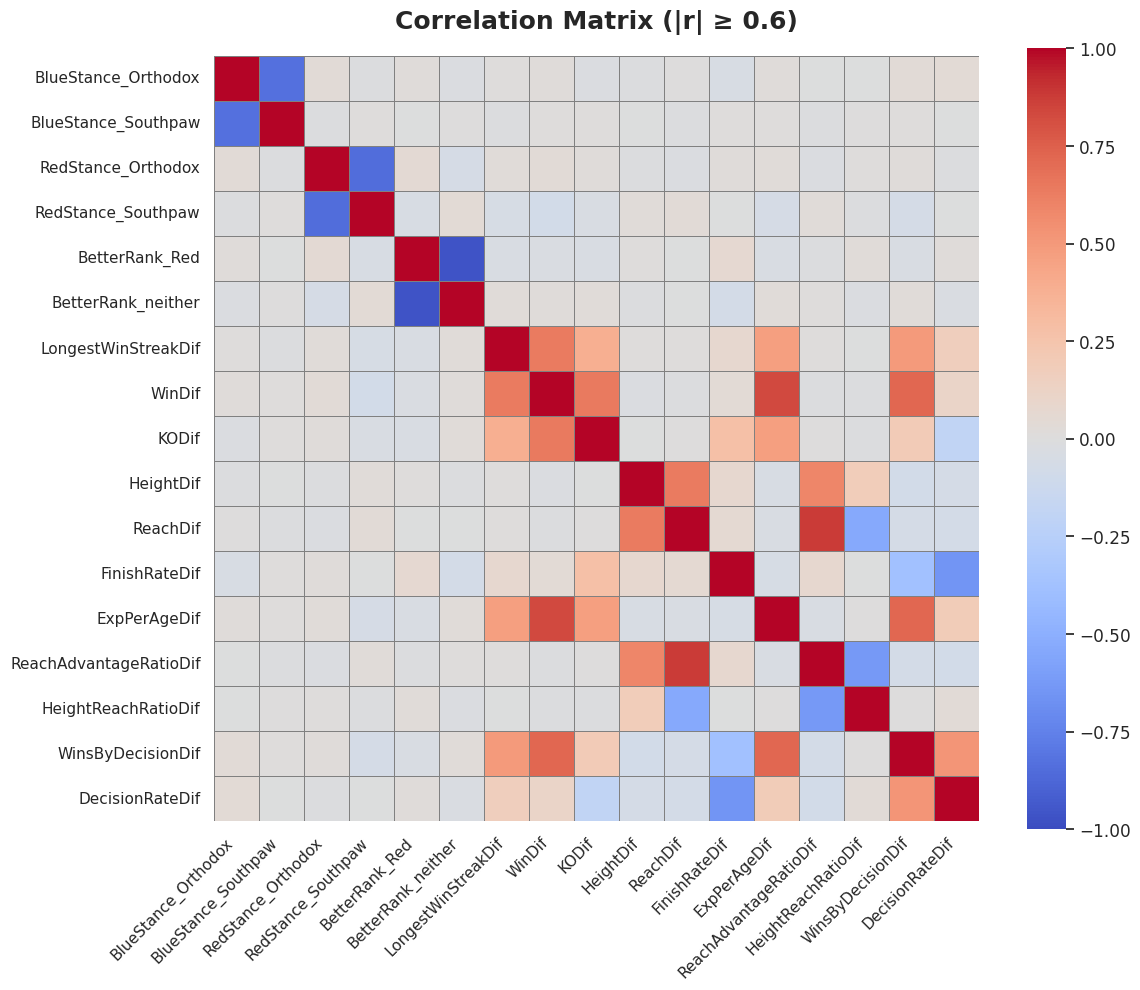

In [30]:
ufc_data.plot_corr(processed = status, threshold = 0.6)

## 14. Check Modeling Data

In [31]:
ufc_data._X_train_processed

,TitleBout,Gender_MALE,BlueStance_Open Stance,BlueStance_Orthodox,BlueStance_Southpaw,BlueStance_Switch,RedStance_Open Stance,RedStance_Orthodox,RedStance_Southpaw,RedStance_Switch,...,ExpPerAgeDif,ReachAdvantageRatioDif,HeightReachRatioDif,WinsByDecisionDif,DecisionRateDif,OddsDif,AvgSigStrLandedDif,AvgSigStrPctDif,AvgTDLandedDif,AvgTDPctDif
1537,0,1,0,1,0,0,0,1,0,0,...,1.886513,-2.877471,1.026335,2.955629,1.581807,0.701065,0.007183,-0.297743,2.315626,1.213697
923,0,1,0,0,0,1,0,1,0,0,...,0.376111,1.549662,-1.136039,0.640542,2.229866,-1.744037,0.191586,-0.442174,-0.957738,0.158494
3170,0,1,0,1,0,0,0,0,1,0,...,0.155658,-0.292983,0.343934,0.640542,2.229866,0.643758,1.965728,-1.200436,0.046903,0.062567
2791,0,1,0,1,0,0,0,1,0,0,...,0.296953,1.176218,0.054811,0.254694,0.069670,-0.311360,-0.148443,-1.669836,0.046903,0.062567
688,0,1,0,1,0,0,0,1,0,0,...,0.304868,-0.609817,1.160082,0.254694,0.789735,0.424081,-0.112620,-0.586605,-0.267737,0.861963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,0,1,0,1,0,0,0,0,1,0,...,0.457177,-0.893301,0.316376,0.254694,-0.046055,0.299915,-0.666310,-0.131648,0.297842,-0.042953
4641,0,1,0,1,0,0,0,1,0,0,...,0.445893,-0.836309,0.631631,0.254694,0.069670,0.510041,-0.500805,0.243873,0.322903,0.718072
3275,0,1,0,1,0,0,0,1,0,0,...,2.371127,-0.305665,-0.451359,-0.902849,-1.478470,0.892088,-1.119224,0.742159,-0.212317,-0.746422
4731,0,1,0,0,1,0,0,0,1,0,...,0.349546,0.007177,-2.068112,0.640542,1.149768,1.111766,0.879279,-1.272652,-4.093103,-0.097312


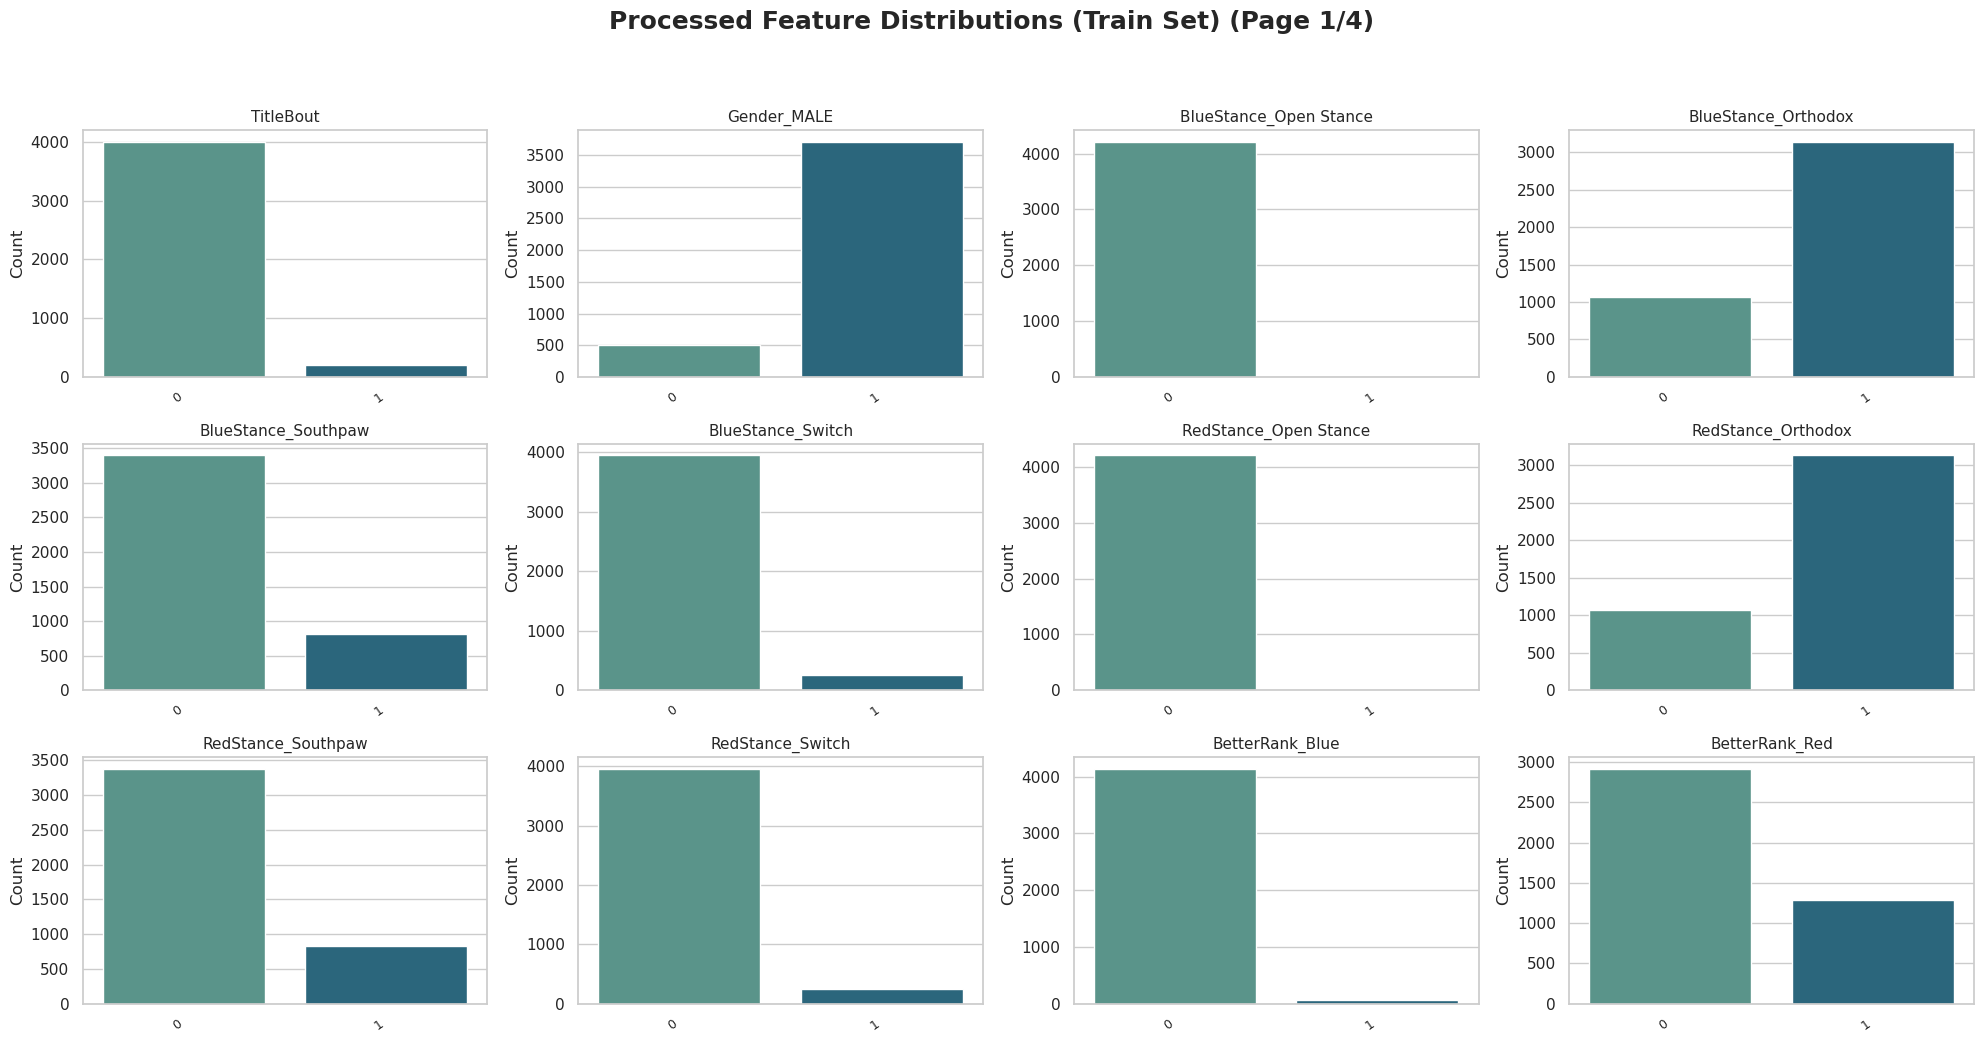

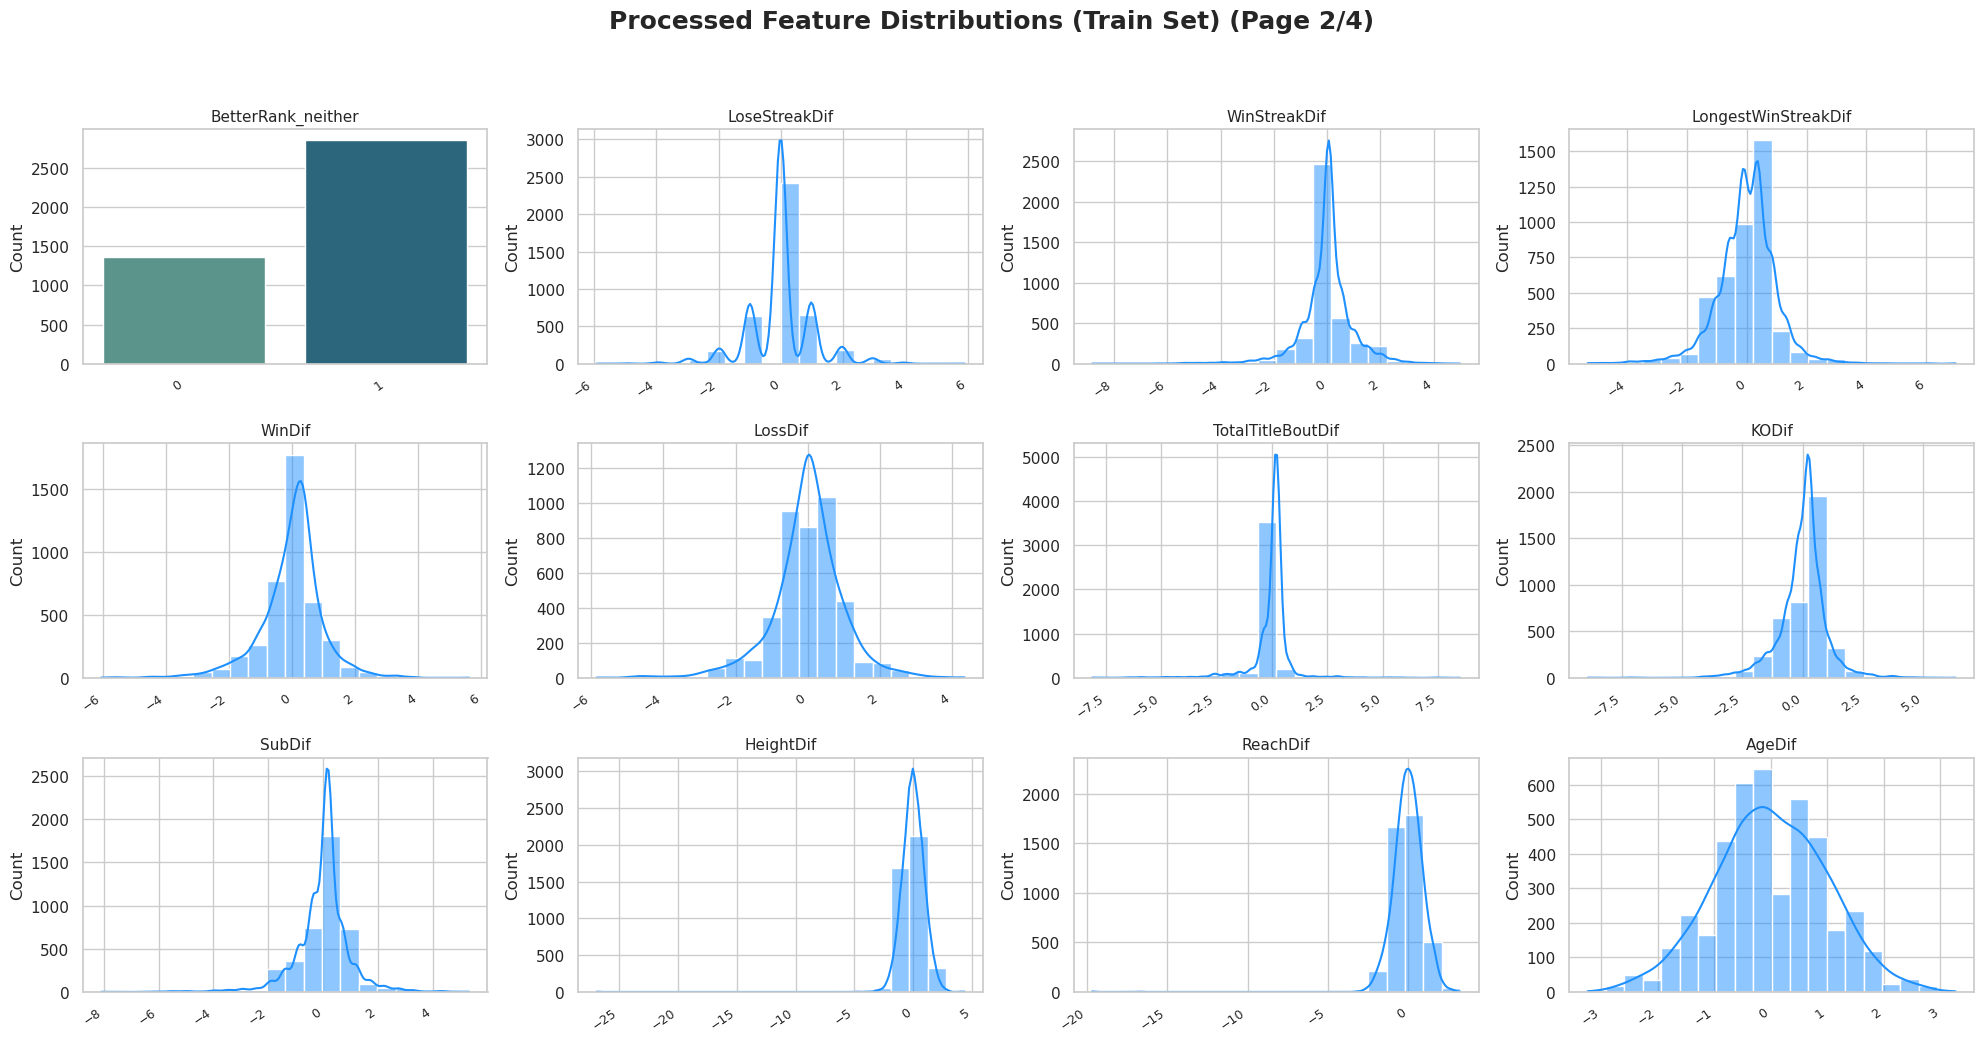

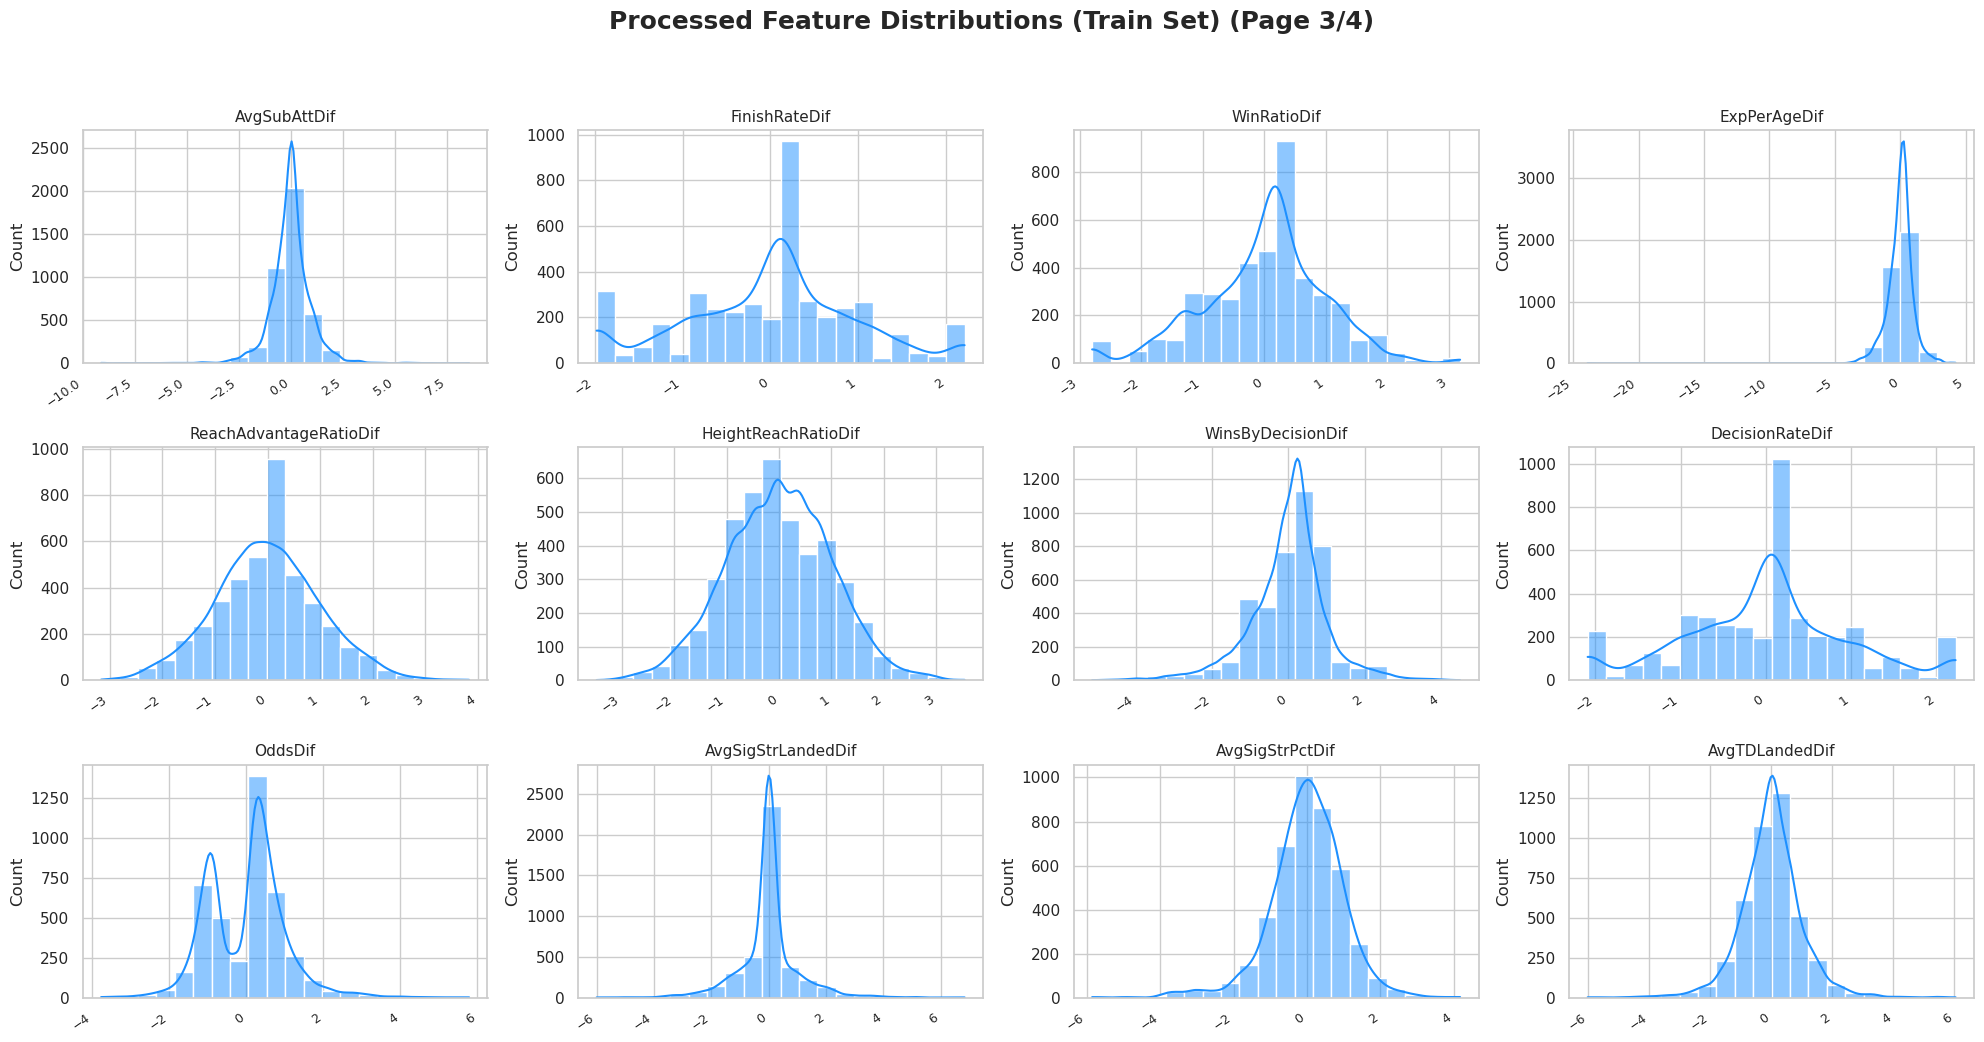

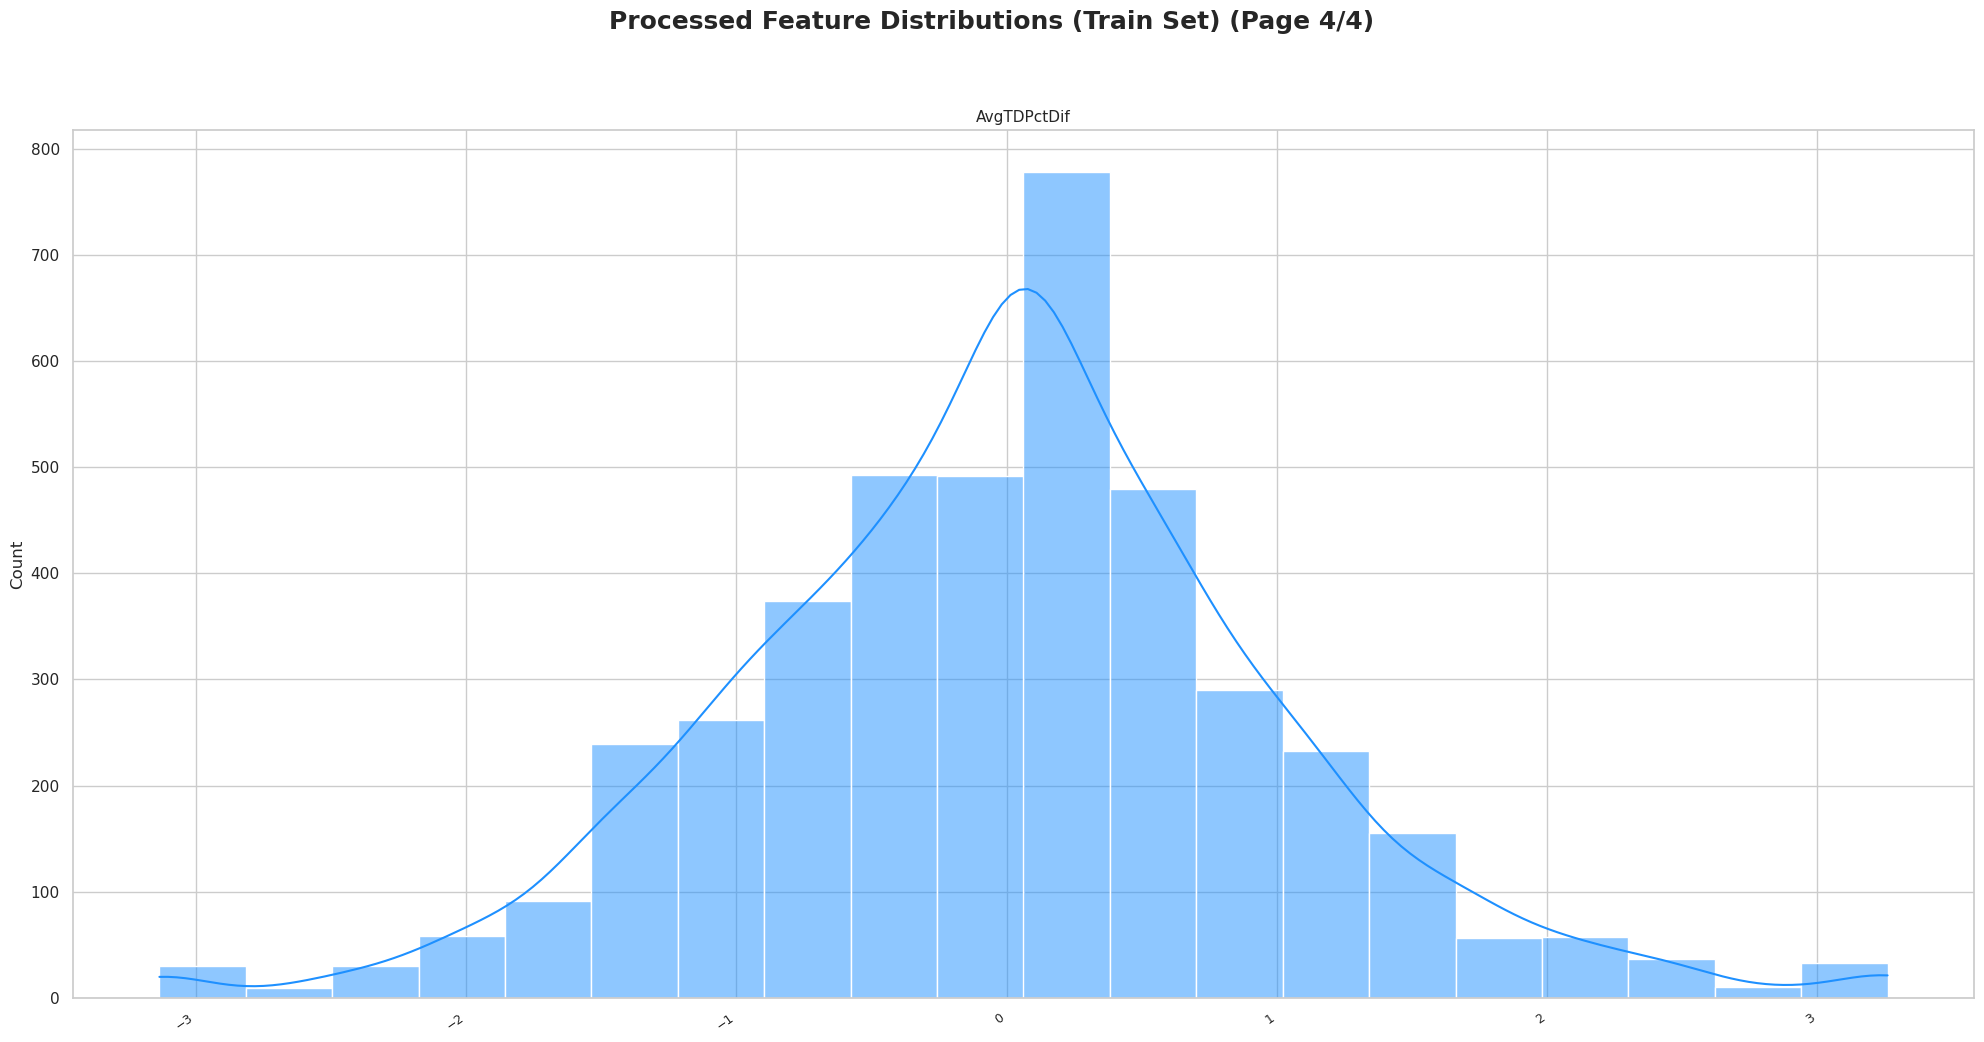

In [32]:
ufc_data.plot_feature_distributions(processed = True)

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 15. Save

In [33]:
ufc_modeling_data = ufc_data

In [34]:
save_data(ufc_modeling_data)

✅ UFCData object saved to: /home/mlioi/ufc-predictor/data/processed/ufc_data.pkl


In [35]:
save_ufc_datasets(ufc_modeling_data, project_root)

✅ UFCData object saved to: dict_keys(['ufc_train.csv', 'ufc_test.csv', 'ufc_processed_train.csv', 'ufc_processed_test.csv'])


<div style="text-align: center;">
     <img src="../img/ufc_logo.png" width="800" /> 
</div>